In [4]:
import torch
import numpy as np
import sys, os
import matplotlib.pyplot as plt

from PGM.utilities import RBM_utils
from utils.plots import *
from data.reshape_data import *

In [3]:
sys.path.append('/home/casperpeters/Documents/codes/intern/PGM/source')
sys.path.append('/home/casperpeters/Documents/codes/intern/PGM/utilities')
sys.path.append('/home/casperpeters/Documents/codes/intern/PGM')

In [18]:
# load rbm thijs
rbm = RBM_utils.loadRBM('/home/sebastian/Desktop/PGM/data/Zebrafish/cRBM_models/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data')

# load data
spikes = np.load('/home/sebastian/Desktop/PGM/data/Zebrafish/neural_recordings/full_spike-only_data_sets/20180912_Run01_spontaneous_rbm2__wb_spikes_only.npy')

# import neuron indexes Thijs used
neuron_idx = np.load('/home/casperpeters/Documents/codes/intern/data/spike_idx.npy')

In [19]:
# split in train and test set
# in the cRBM paper, they split the dataset in 10 part, of which 2, 6, 7 are test sets
# we have to use this same split, but use smaller batches because otherwise the cuda is full
batches = 10
test_batches = np.array([2, 6, 7]) - 1
train_batches = np.array([1, 3, 4, 5, 8, 9, 10]) - 1
data = torch.tensor(spikes).T
batch_size = data.shape[1] // batches
batched_data = torch.zeros(data.shape[0], batch_size, batches)
for j in range(batches):
    batched_data[:, :, j] = data[:, batch_size * j:batch_size * (j + 1)]

test = batched_data[:, :, test_batches]
train = batched_data[:, :, train_batches]

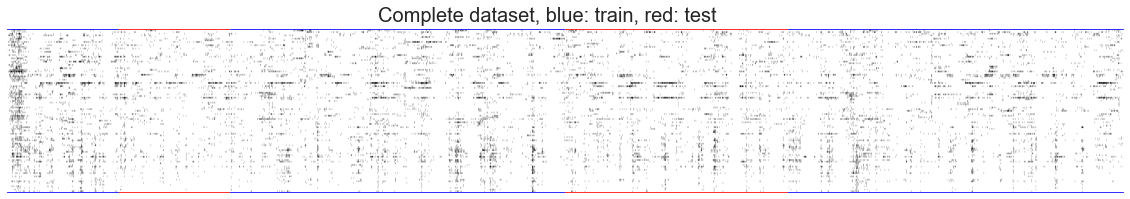

In [32]:
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(batched_data[:100, :, i], cmap=plt.get_cmap('binary'), aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['top', 'bottom']:
        ax.spines[spine].set_visible(True)
        if i in test_batches:
            ax.spines[spine].set_color('red')
        else:
            ax.spines[spine].set_color('blue')

plt.subplots_adjust(wspace=0)
fig.suptitle('Complete dataset, blue: train, red: test', fontsize = 20)
plt.show()

In [ ]:
da = data[]

train, test = train_test_split(torch.tensor(spikes).T, train_batches=300, test_batches=50)

rtrbm = RTRBM(train, N_H=rbm.weights.shape[0], debug_mode=True, device='cuda')

# impose rbm weights to rtrbm
rtrbm.W = torch.tensor(rbm.weights, device='cuda')
rtrbm.b_V = torch.ones(1, rbm.weights.shape[1], device='cuda') * -4
rtrbm.params = [rtrbm.W, rtrbm.U, rtrbm.b_H, rtrbm.b_V, rtrbm.b_init]
rtrbm.learn(n_epochs=10000, lr=1e-3, mom=0, wc=0, sp=1e-6, x=2, batch_size=50, save_every_n_epochs=500)

rtrbm.test = test

os.chdir('/home/casperpeters/Documents/codes/intern/')
save_path = 'results/full_brain/thijs_weights_rtrbm_lr1e-3_epo2000.pt'
torch.save(rtrbm, save_path)